In [1]:
!pip install openpyxl

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 250.0/250.0 kB 18.6 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
import math
import openpyxl
import matplotlib.pyplot as plt

In [98]:
file_path = "data/ESG_raw_data_07_02.xlsx"
file_sect = "data/secteurs.csv"
corresp_secteurs = pd.read_csv(file_sect, sep=";")
data = pd.read_excel(file_path)
data = data.join(corresp_secteurs.set_index('primary_industry'), on = "primary_industry")

In [99]:
secteurs = pd.unique(data["secteur"])

In [100]:
variables_env = ["scope_1", "scope_2", "scope_3", "waste_production", "waste_recycling", 
                 "water_consumption", "water_withdrawal", "energy_consumption"]

data = data.dropna(subset = ["employees"])
data = data.loc[data["employees"] != 0]
for v in variables_env :
    data[v] = data[v]/data["employees"]

## Distributions sectorielles des émissions 

Dans cette partie, on visualise les distributions sectorielles d'émissions. On prend les moyennes des entreprises sur les 3ans étudiés (ou moins si données pas disponibles). On voit rapidement apparaître des "très mauvais élèves" qui tirent la distributions vers la droite et empêchent la bonne visualisation, dans cette partie on se concentre donc sur les entreprises en dessous d'un certain quantile (90%).

In [148]:
def hist(scope, sec, per) :
    df = data.loc[data["secteur"] == sec]
    df = df.dropna(subset = scope)
    df = df.groupby('company_id')[scope].mean().reset_index()
    nbr = df.shape[0]
    
    quantile = df[scope].quantile(1 - per)
    df = df.loc[df[scope] <= quantile]
    nbr = nbr - df.shape[0]
    
    var = df[scope].var()
    mean = df[scope].mean()
    df[scope] = (df[scope]-mean)/np.sqrt(var)
    print(sec + " : " + str(nbr))
    return df

In [180]:
def visualisation_hist(scope, per) :
    plt.figure(figsize=(12, 20))
    print("Nombres d'entreprises mises de côté par secteur, en prenant le quantile " + str(100*(1 - per)) + "%")
    
    i = 1
    for s in secteurs :
        df = hist(scope, s, per)
        plt.subplot(4,3,i)
        plt.hist(df[scope], bins = 100)
        plt.title(s)
        plt.xlabel(scope + " normalisé")
        #plt.xlim([-3, 3])
        i += 1
    
    plt.suptitle("Histogrammes de " + scope, fontsize=16)
    plt.show()

Nombres d'entreprises mises de côté par secteur, en prenant le quantile 90.0%
Information Technology : 82
Energy : 28
Communication Services : 36
Consumer Staples : 67
Consumer Discretionary : 81
Financials : 100
Health Care : 78
Industrials, commercial and transportation : 62
Industrials, capital goods : 77
Utilities : 28
Materials : 65
Real Estate : 24


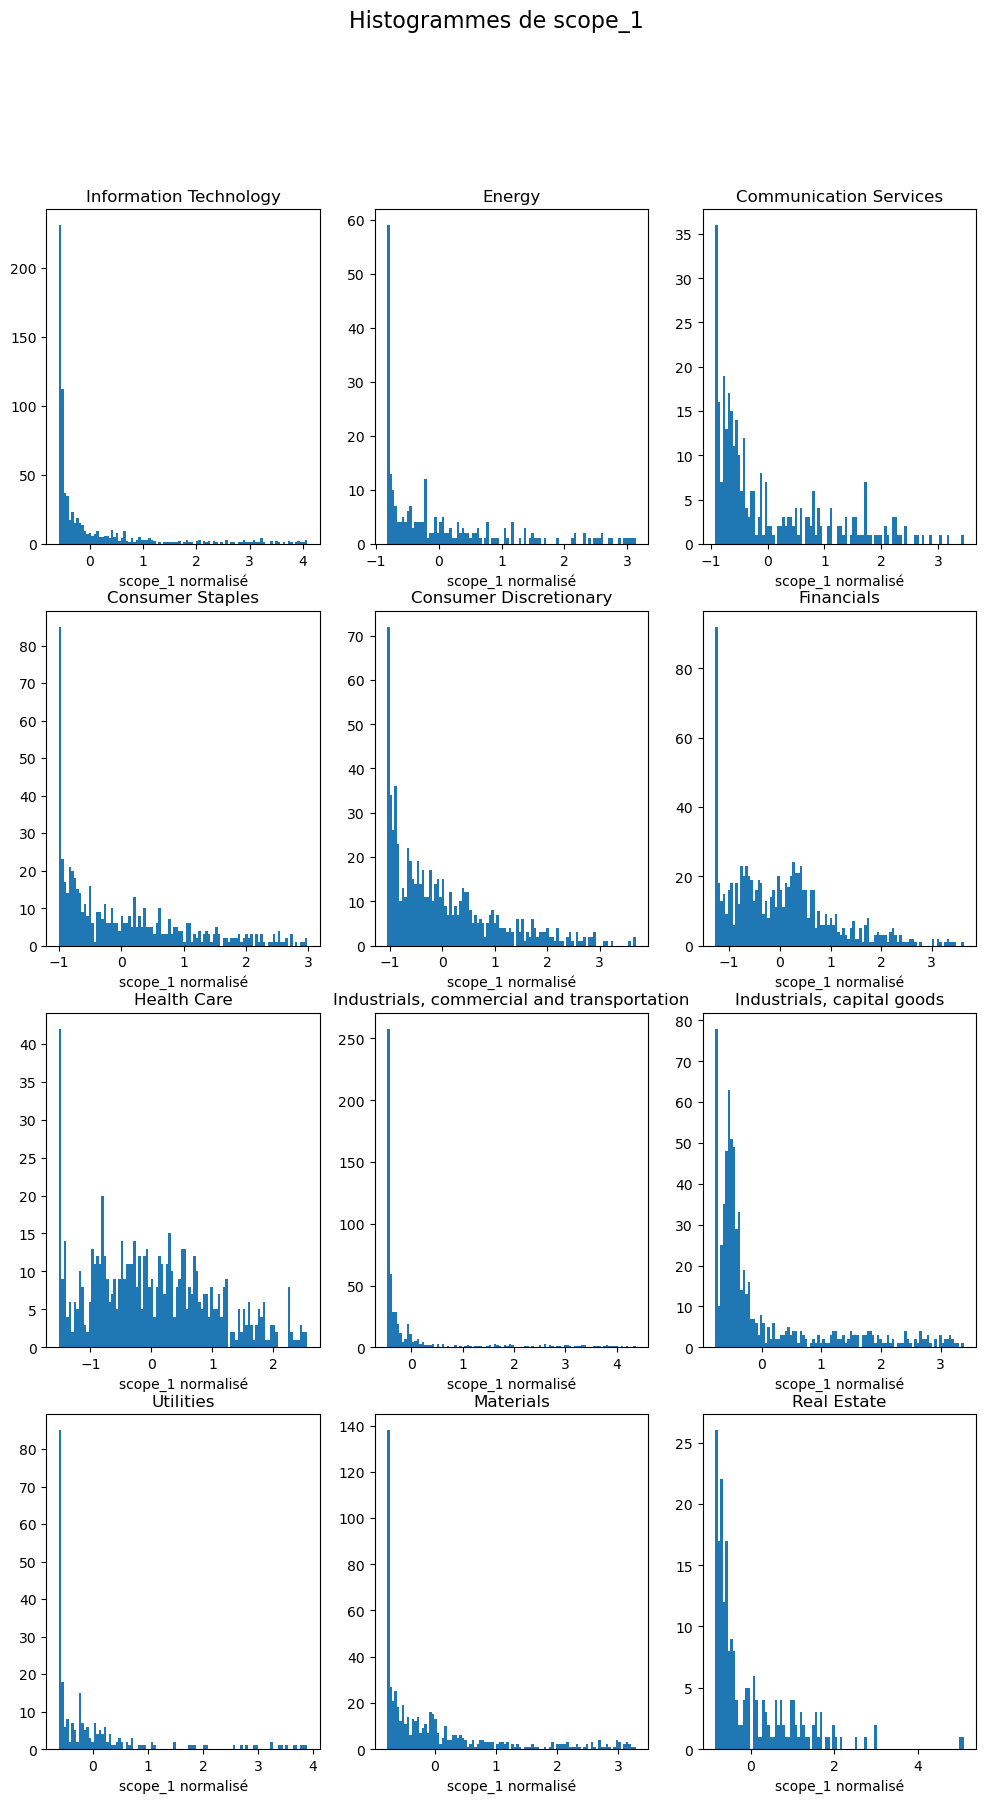

In [181]:
visualisation_hist("scope_1", 0.1)

Nombres d'entreprises mises de côté par secteur, en prenant le quantile 90.0%
Information Technology : 84
Energy : 28
Communication Services : 37
Consumer Staples : 68
Consumer Discretionary : 82
Financials : 101
Health Care : 79
Industrials, commercial and transportation : 63
Industrials, capital goods : 79
Utilities : 28
Materials : 67
Real Estate : 25


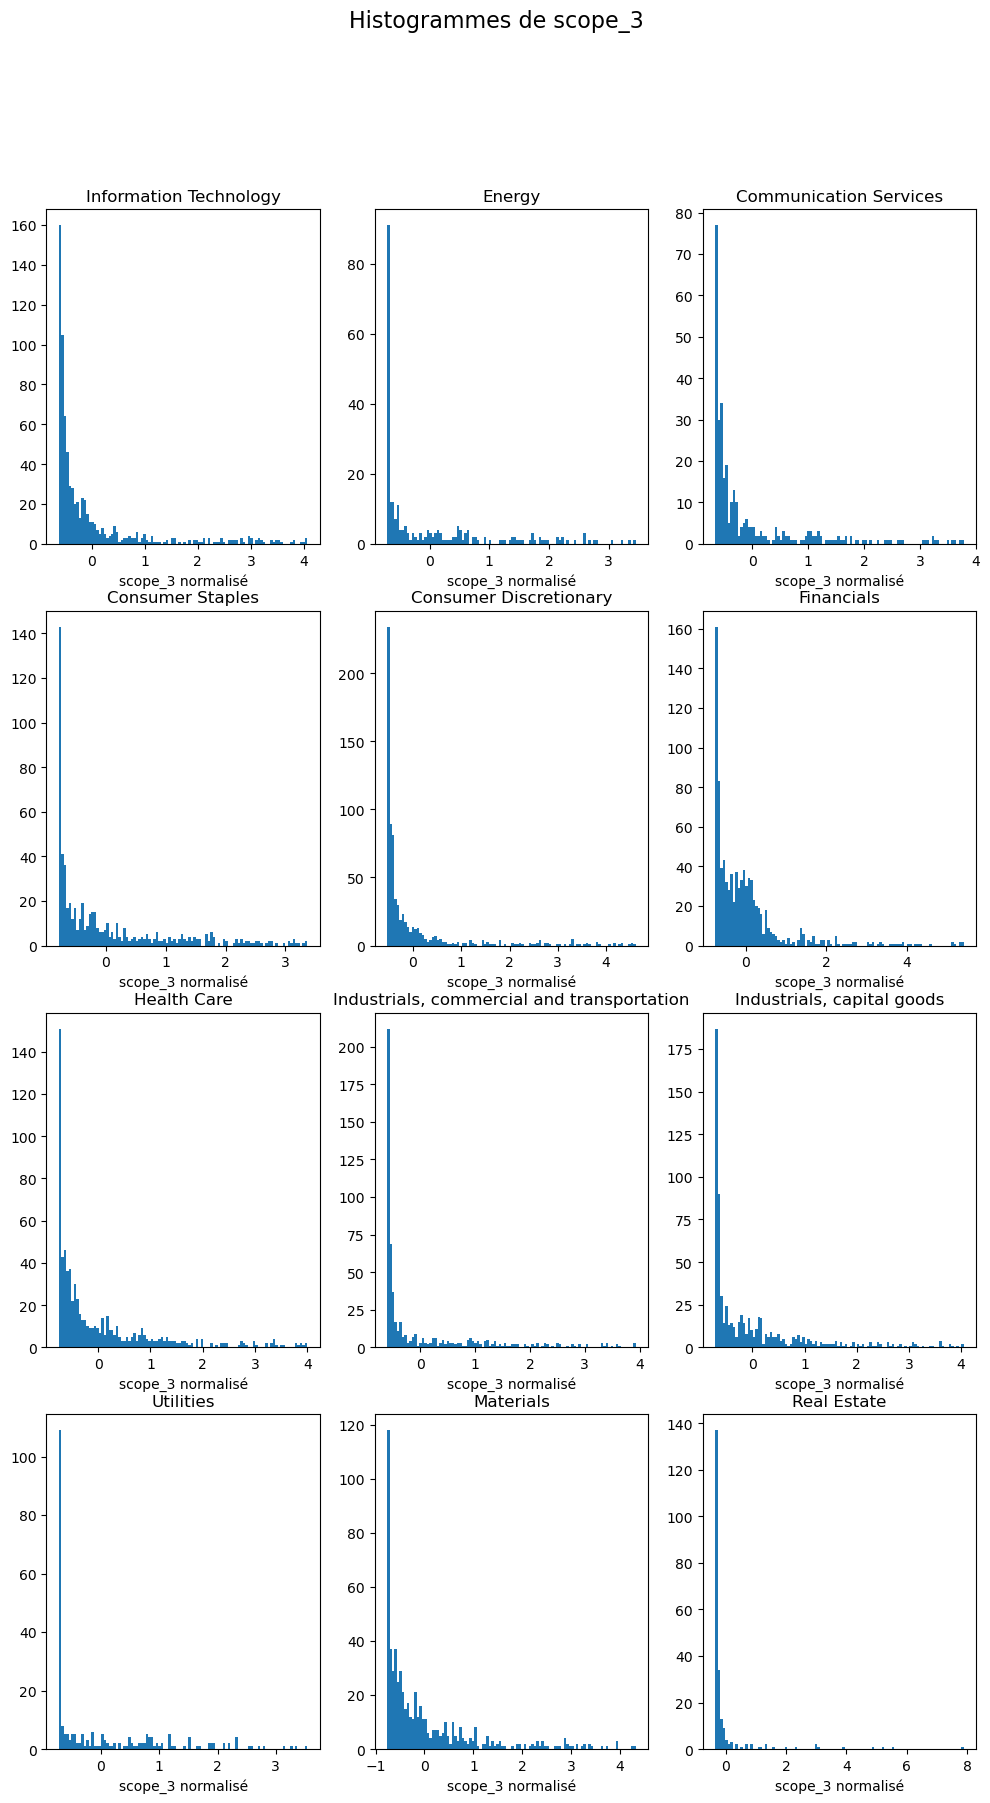

In [182]:
visualisation_hist("scope_3", 0.1)

On voit que en scope 3, on a beaucoup plus de valeurs proches de zéro. Cela peut être dû à : 1) plus d'outliers pour cette scope, ce qui fait ramener les autres entreprises proches de la moyenne relativement (on le voit dans les valeurs prises sur l'axe des abscisses, plus importantes pour le scope 3), 2) "un moins bon reporting" des entreprises, qui ne compte que peu d'émissions en scope 3, ce qui fait que celles qui jouent le jeu et compte bien ont des émissions bien plus importantes.

## Position sectorielle scope 1 et 3

On va relier la "position sectorielle" des entreprises en scope 1 et 3.

In [165]:
def pos(sec) :
    df = data.loc[data["secteur"] == sec]
    df = df.dropna(subset = ["scope_1", "scope_3"])
    df = df.groupby('company_id')[["scope_1", "scope_3"]].mean().reset_index()
    
    df['classement_scope_1'] = df["scope_1"].rank(ascending=False)
    df['classement_scope_3'] = df["scope_3"].rank(ascending=False)
    return df

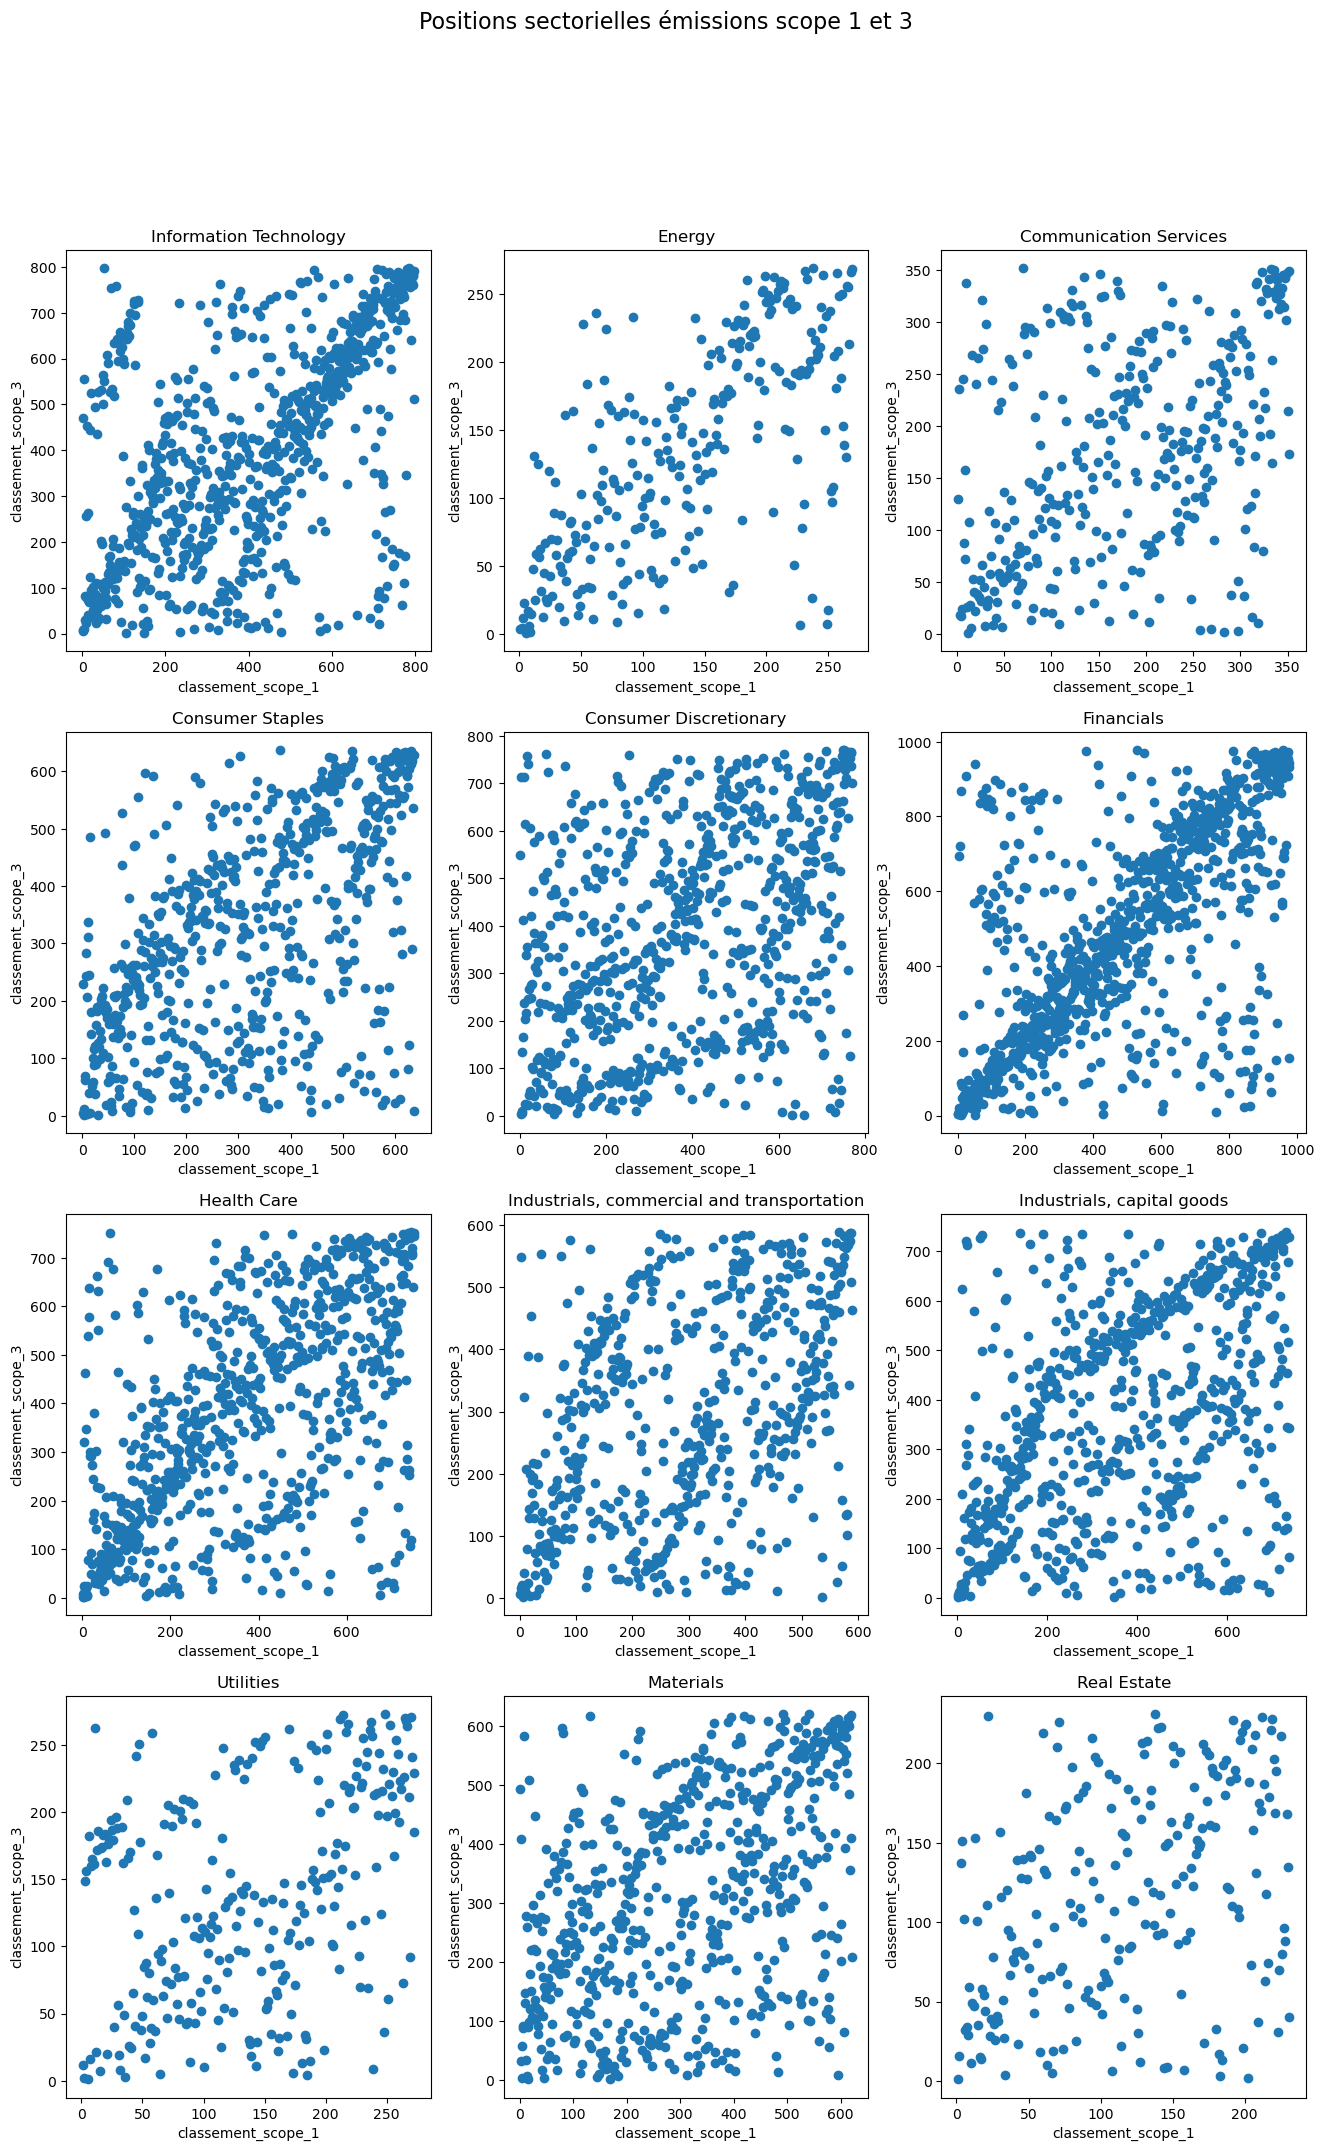

In [167]:
plt.figure(figsize=(16, 24))
    
i = 1
for s in secteurs :
    df = pos(s)
    plt.subplot(4,3,i)
    plt.scatter(df['classement_scope_1'], df['classement_scope_3'])
    plt.title(s)
    plt.xlabel('classement_scope_1')
    plt.ylabel('classement_scope_3')
    i += 1
    
plt.suptitle("Positions sectorielles émissions scope 1 et 3", fontsize=16)
plt.show()

## Relation entre taille de l'entreprise et "écart à la moyenne/médiane"

On étudie la relation qu'il peut y avoir entre taille de l'entreprise (en termes d'employés) et son écart à la moyenne sectorielle.

In [168]:
def ecart(scope, sec, per) :
    df = data.loc[data["secteur"] == sec]
    df = df.dropna(subset = scope)
    df = df.groupby('company_id').agg({scope : 'mean', 'employees': 'mean'}).reset_index()
    
    quantile = df[scope].quantile(1 - per)
    df = df[df[scope] <= quantile]
    
    mean = df[scope].mean()
    med = df[scope].median()
    var = df[scope].var()
    
    df["ecart_mean"] = (df[scope]-mean)/np.sqrt(var)
    df["ecart_med"] = (df[scope]-med)/np.sqrt(var)
    return df

In [183]:
def visualisation2(scope, x, per) :

    plt.figure(figsize=(16, 24))
    
    i = 1
    for s in secteurs :
        if x == 0 : m = "ecart_mean"
        else : m = "ecart_med"
            
        df = ecart(scope, s, per)
        plt.subplot(4,3,i)
        plt.scatter(df["employees"]/df["employees"].mean(), df[m])
        plt.title(s)
        plt.xlabel("employees normalisé")
        plt.ylabel(m)
        i += 1
    
    plt.suptitle("Relation entre taille (employés) et " + m + " des émissions " + scope, fontsize=16)
    plt.show()

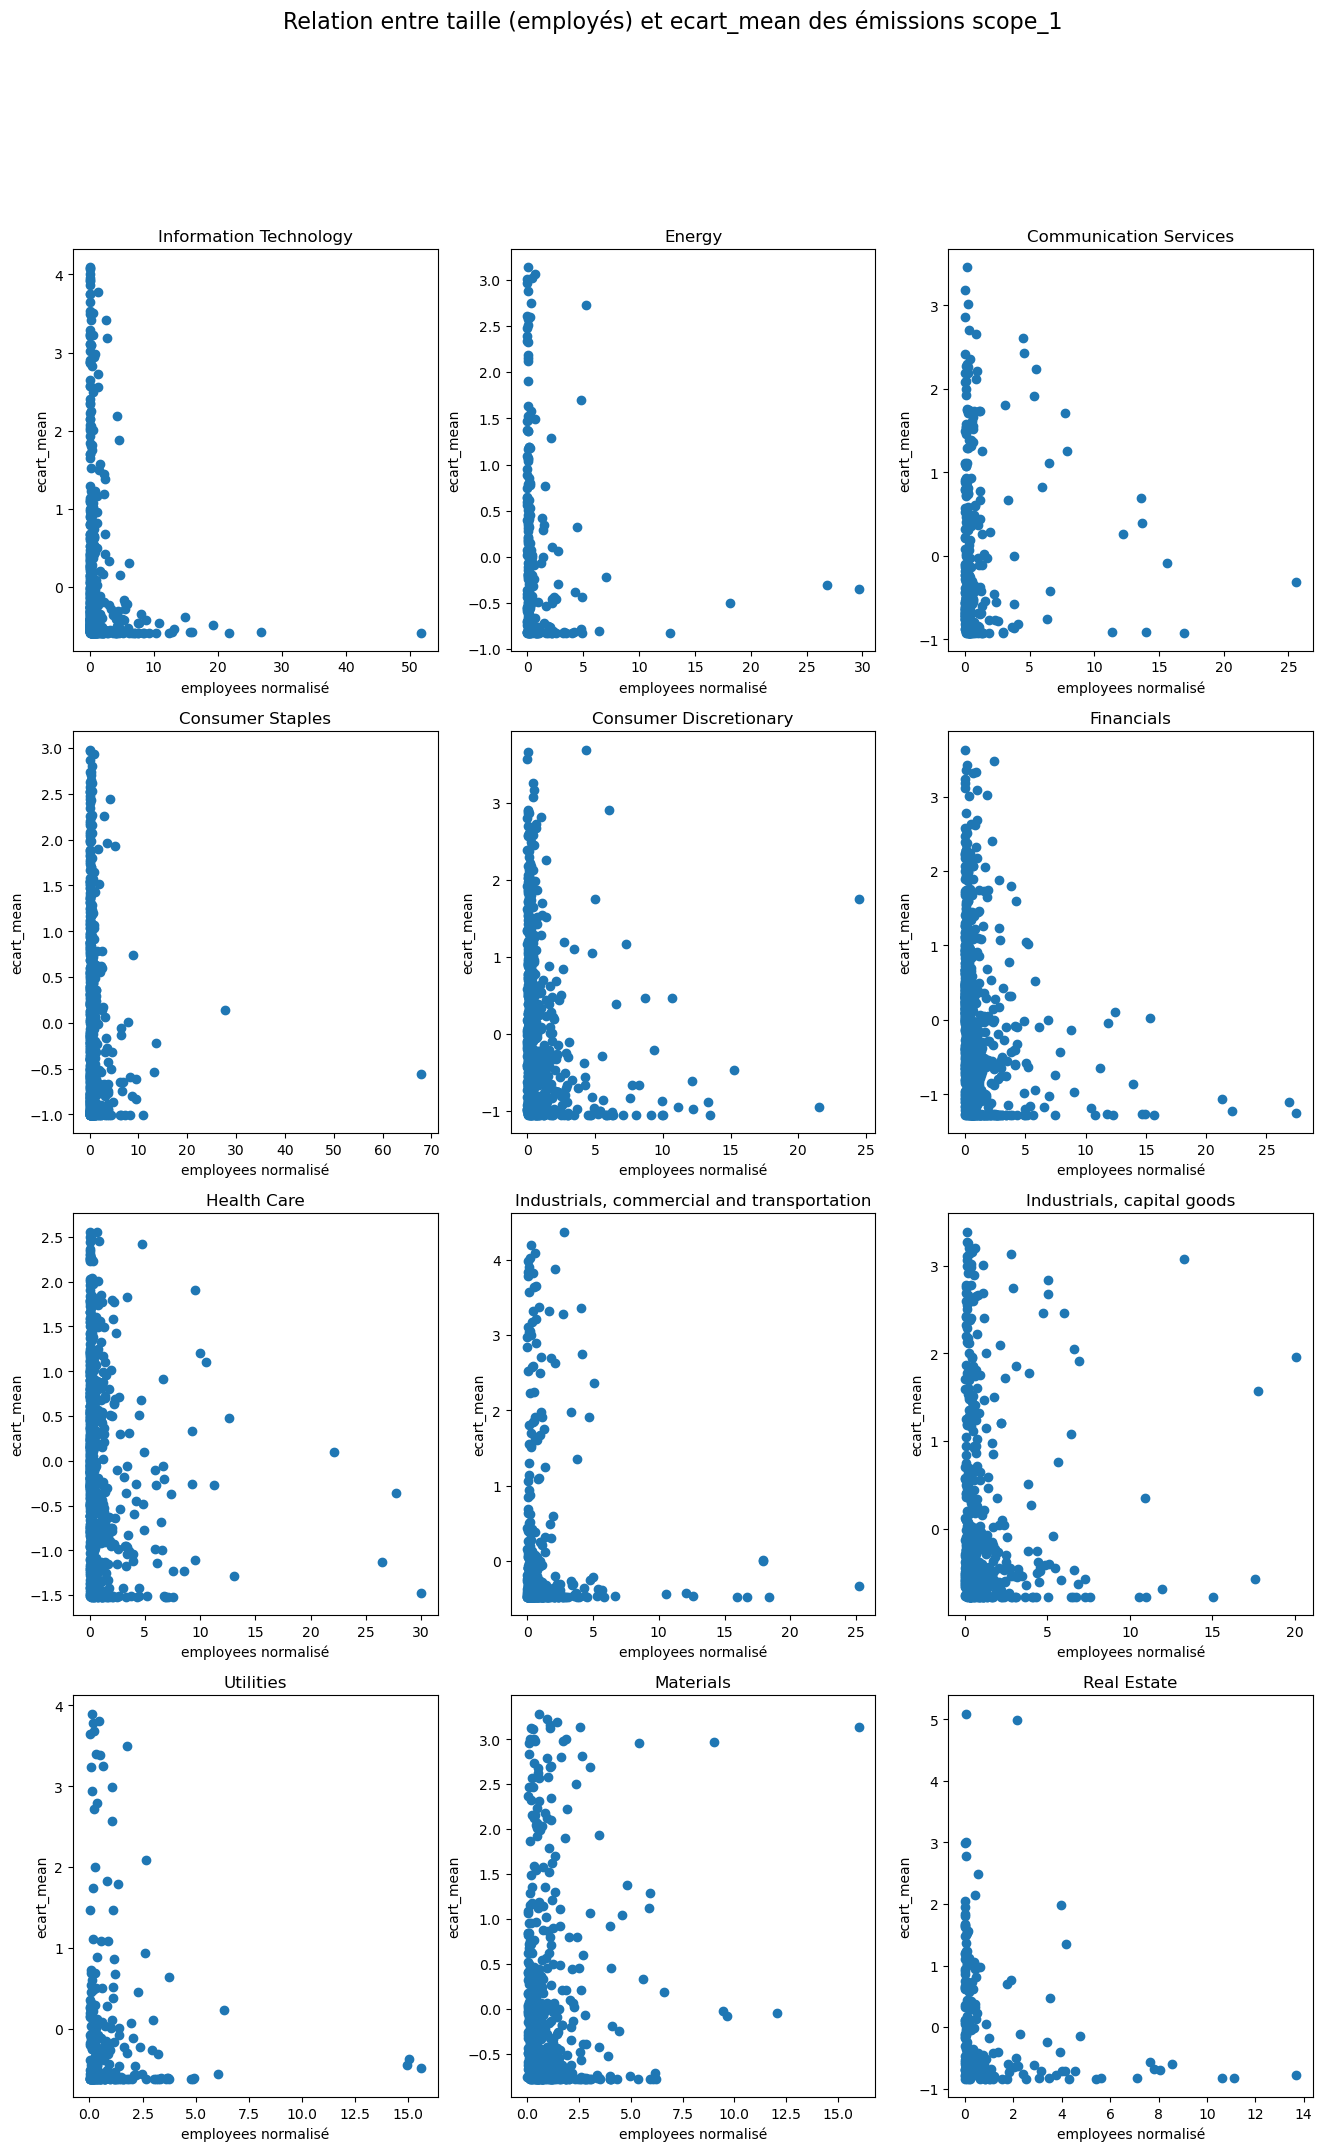

In [184]:
visualisation2("scope_1", 0, 0.1)

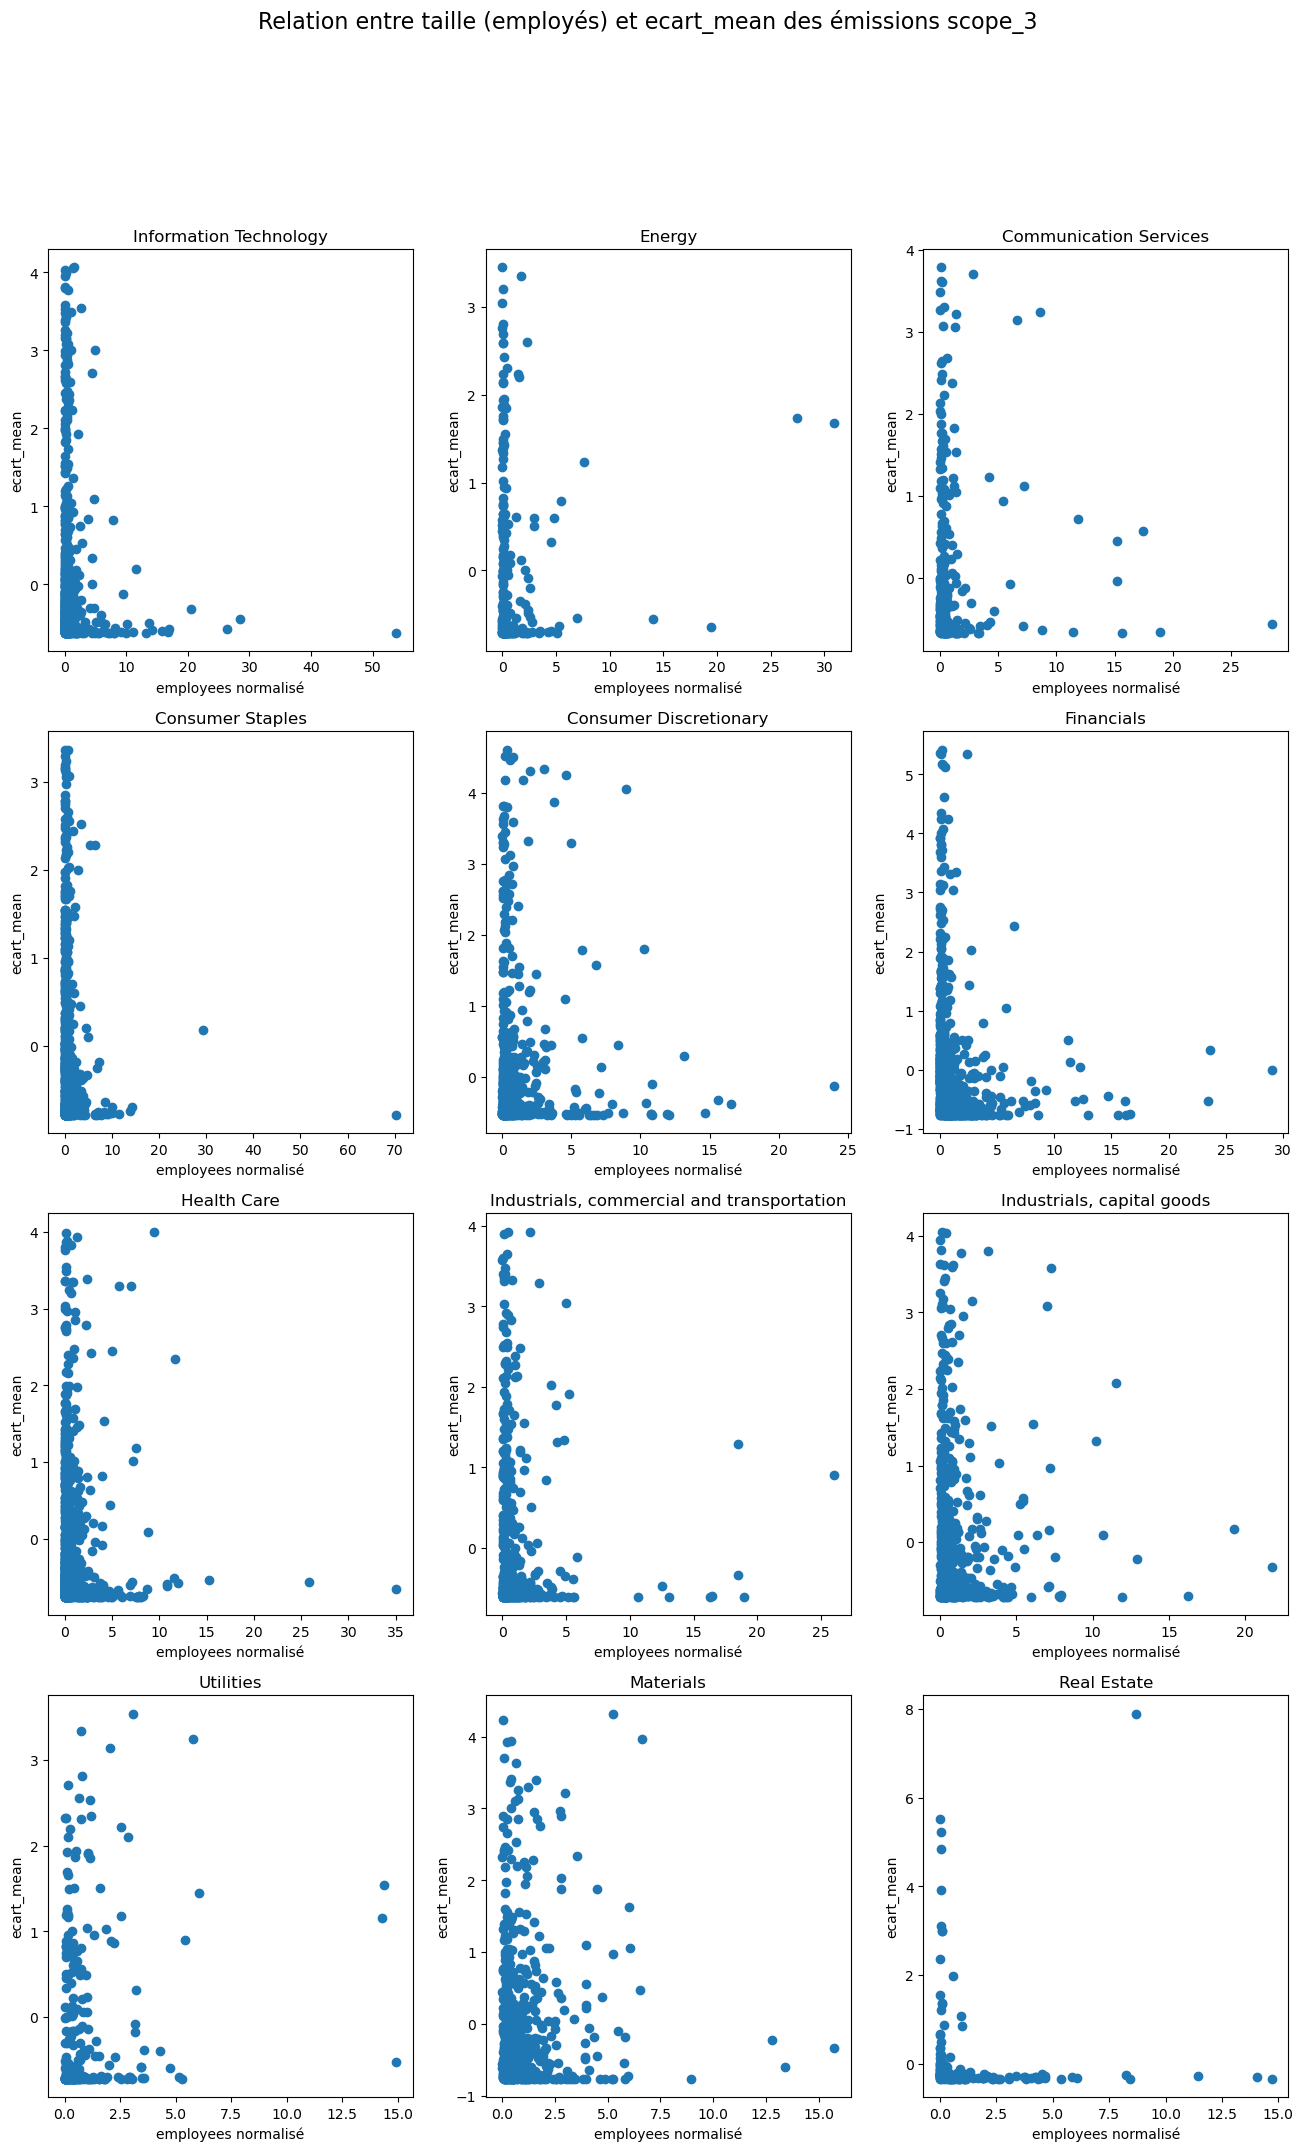

In [185]:
visualisation2("scope_3", 0, 0.1)

## Simplement, relation entre scope 1 et 3 par secteur

In [188]:
def visualisation3(per) :
    plt.figure(figsize=(16, 24))
    i = 1
    
    for sec in secteurs :
        df = data.loc[data["secteur"] == sec]
        df = df.dropna(subset = ["scope_1", "scope_3"])
        df = df.groupby('company_id')[["scope_1", "scope_3"]].mean().reset_index()
    
        quantile1 = df["scope_1"].quantile(1 - per)
        df = df[df["scope_1"] <= quantile1]
        quantile3 = df["scope_3"].quantile(1 - per)
        df = df[df["scope_3"] <= quantile3]

        plt.subplot(4,3,i)
        plt.scatter(df['scope_1'], df['scope_3'])
        plt.title(s)
        plt.xlabel('scope_1')
        plt.ylabel('scope_3')
        
        i += 1
        
    plt.suptitle("Relations sectorielles scope 1 et 3", fontsize=16)
    plt.show()

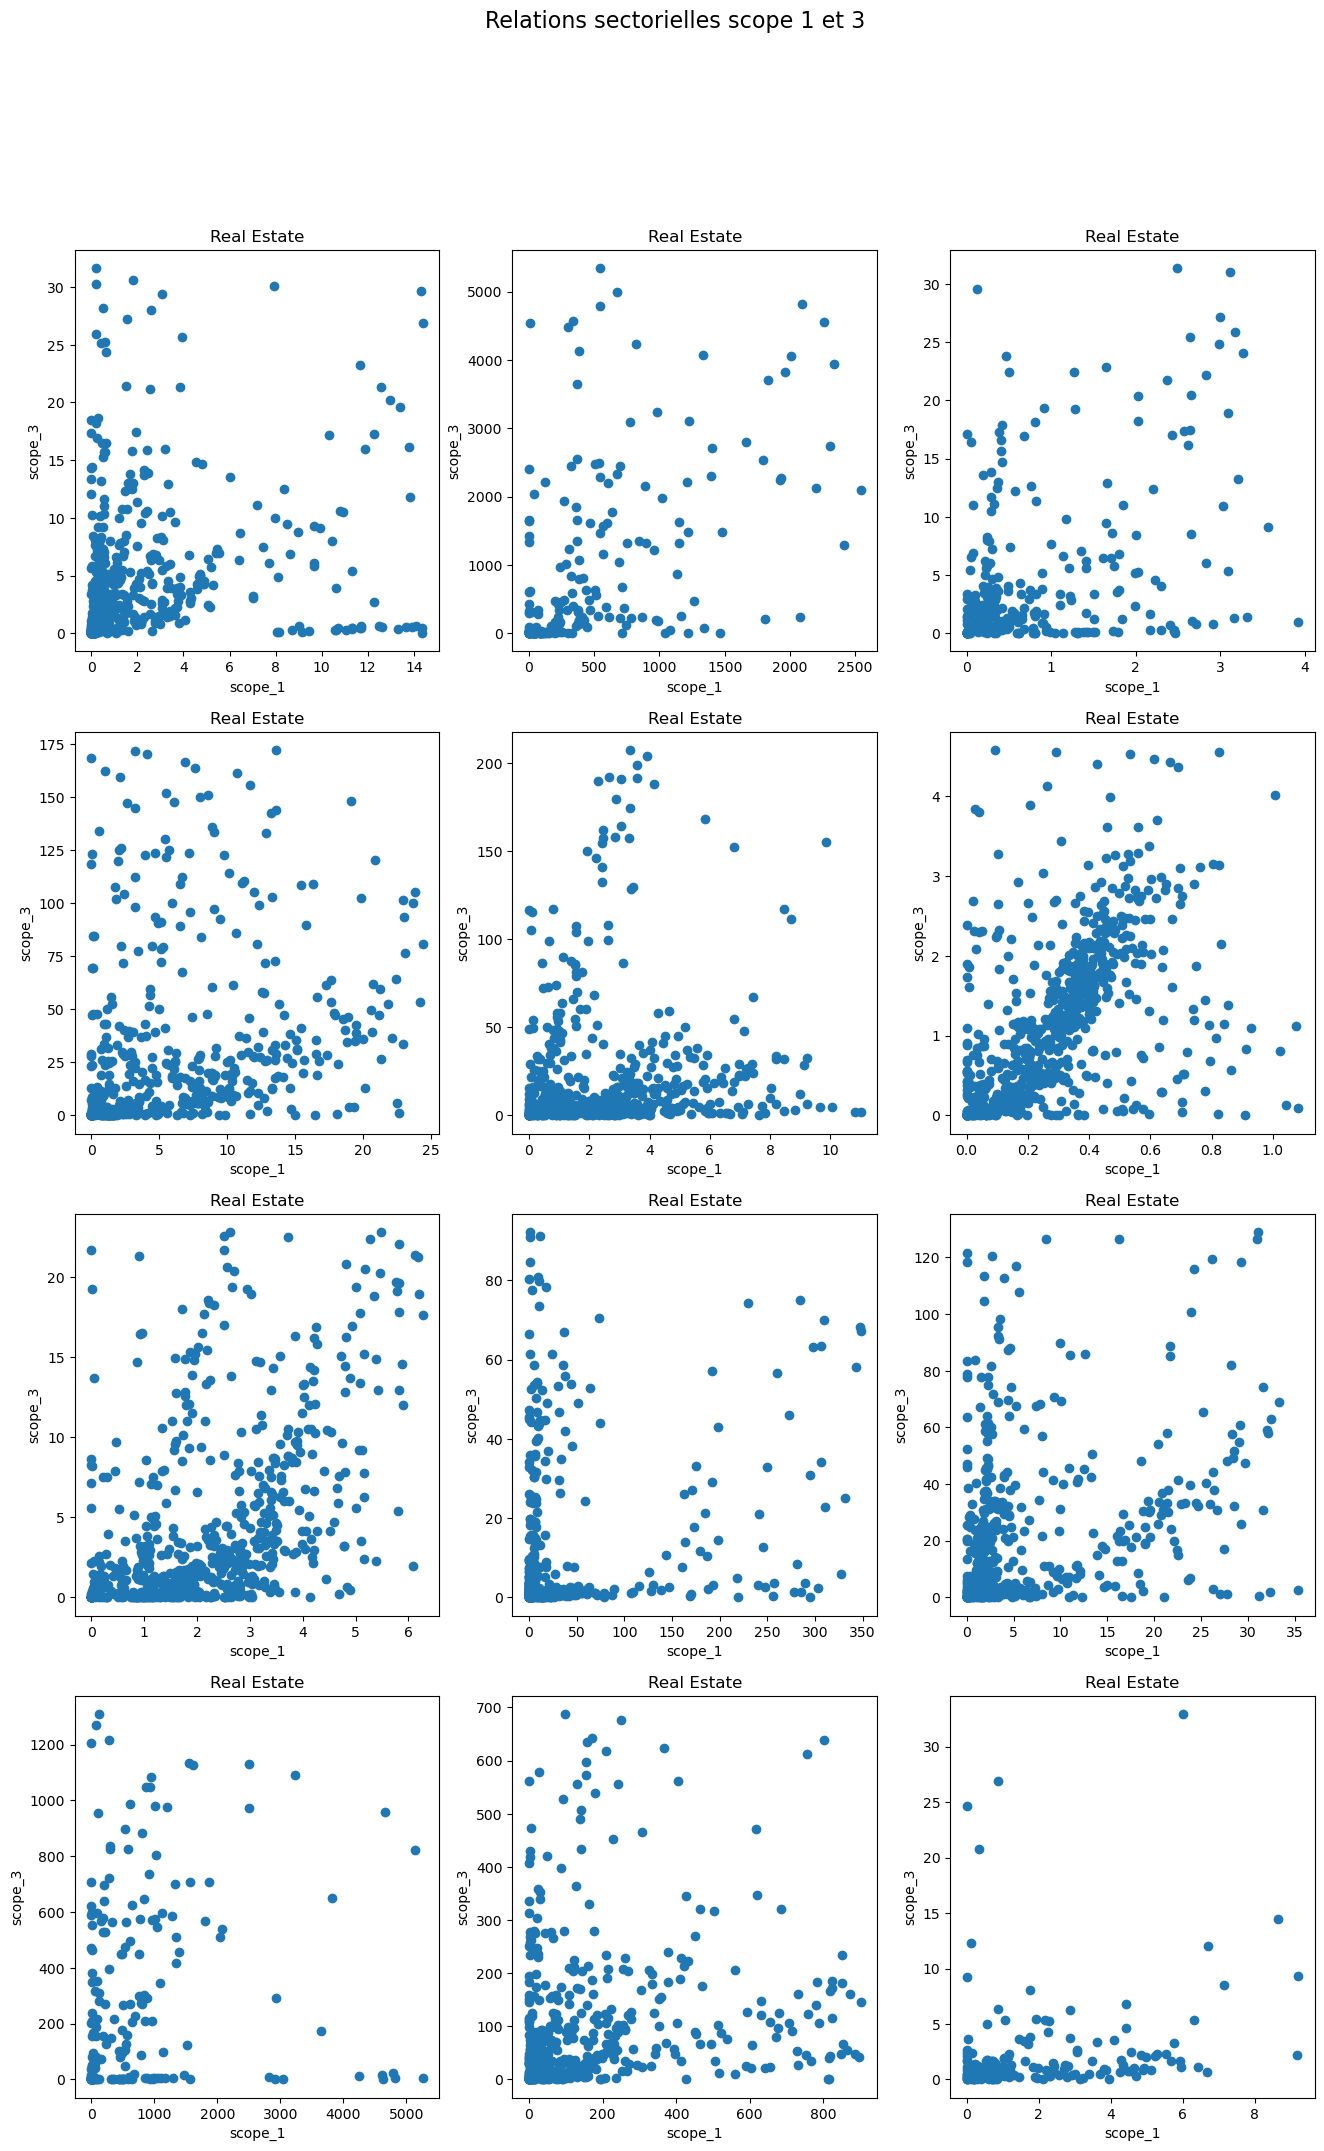

In [189]:
visualisation3(0.1)